## Multivariate Time Series Forecasting with Deep Learning
### Predicting the price of Bitcoin and interpreting the results

This notebook runs the entire forecasting pipeline from data preparation to model training and interpretation.

Alternatively, everything can be run from the terminal as well (see README.md).

Prerequisite: Dataset has been downloaded (see README.md) and parameters have been updated if necessary (see /model/params.yaml).

### Setup

In [94]:
import os
import yaml
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

os.chdir("../scripts")

import preprocess, train, inference, interpret

In [95]:
with open("../model/params.yaml", "r") as params_file:
    params = yaml.safe_load(params_file)

data_dir = params['data_dir']

### Load and Prepare the Data

In [96]:
file_name = "Aluminium.csv"
data = preprocess.load_data(file_name)
data.head(3)

,Date,Close,Open,High,Low,Volume,Change
0,13.10.2013,1816.75,1832.13,1858.63,1796.50,1.05,-2.06
1,20.10.2013,1848.00,1816.75,1858.13,1807.13,0.90,1.72
2,27.10.2013,1806.75,1848.00,1871.50,1823.00,0.16,-2.23


In [97]:
data['Date'] = data['Date'].astype('datetime64[ns]')

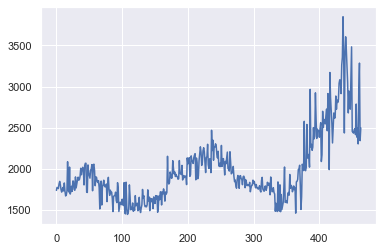

In [98]:
df_clean = data.sort_values(by='Date').reset_index(drop=True)
plt.plot(df_clean['Close'],label='Price')
plt.show()

In [99]:
train_df, test_df = preprocess.prep_data(df=data, train_frac=0.8, plot_df=True)

Starting with data preparation...
Completed.


weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


In [100]:
train_df.shape, test_df.shape

((370, 7), (93, 7))

In [101]:
train_df

,Close,Volume,High_Low_Pct,Open_Close_Pct,Week_of_Year,Month_Of_Year,Quarter_Of_Year
0,0.285575,0.000334,0.209514,0.524240,0.019608,0.000000,0.000000
1,0.321516,0.000475,0.100522,0.427558,0.196078,0.181818,0.000000
2,0.316626,0.000118,0.247209,0.466244,0.627451,0.636364,0.666667
3,0.307090,0.000000,0.112102,0.555356,0.784314,0.818182,1.000000
4,0.362103,0.000344,0.278193,0.470654,0.784314,0.818182,1.000000
...,...,...,...,...,...,...,...
365,0.387286,0.051184,0.154788,0.441785,0.803922,0.818182,1.000000
366,0.393154,0.049046,0.261897,0.464460,0.823529,0.818182,1.000000
367,0.414670,0.057226,0.088692,0.546335,0.882353,0.909091,1.000000
368,0.534474,0.065748,0.335872,0.465431,0.882353,0.909091,1.000000


### Explore the Data

In [102]:
plot_df = pd.read_csv(Path(data_dir, 'plot_df.csv'))
plot_df['Close_Change'] = plot_df.Close.pct_change(1)
plot_df = plot_df.dropna()

In [103]:
plot_df['Close']

1      1775.25
2      1770.25
3      1760.50
4      1816.75
5      1848.00
        ...   
365    1842.50
366    1848.50
367    1870.50
368    1993.00
369    1998.50
Name: Close, Length: 369, dtype: float64

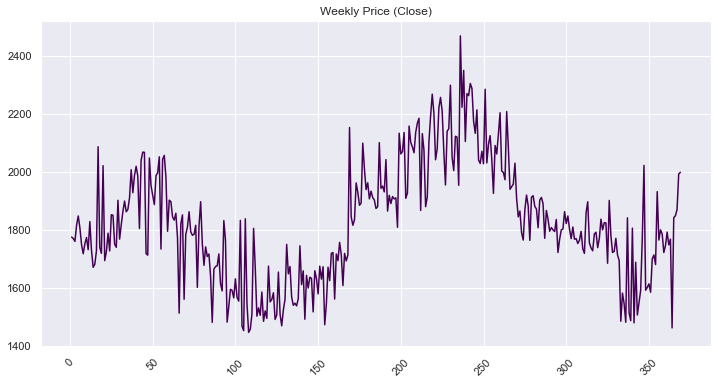

In [104]:
plot_df['Close'].plot(figsize=(12,6), rot=45, cmap='viridis')
plt.title('Weekly Price (Close)')
plt.show()

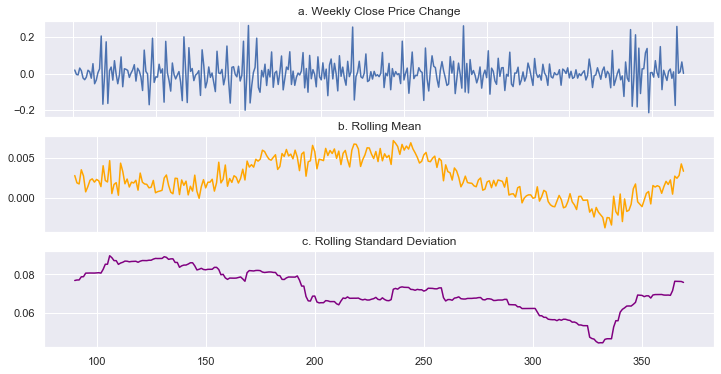

In [105]:
fig, axes = plt.subplots(nrows=3, ncols=1)
plot_df['Close_Change'].plot(ax=axes[0], figsize=(12,6), rot=90, title='a. Weekly Close Price Change', sharex=True)
plot_df['Close_Change'].rolling(90).mean().plot(ax=axes[1], figsize=(12,6), rot=90, title='b. Rolling Mean', color='orange')
plot_df['Close_Change'].rolling(90).std().plot(ax=axes[2], figsize=(12,6), rot=0, title='c. Rolling Standard Deviation', color='purple')
plt.show()

### Train the LSTM model

In [106]:
sequence_length = 30
batch_size = 8
n_epochs = 20
n_epochs_stop = 5
label_name = 'Close'

In [107]:
hist = train.train_model(train_df, test_df, label_name, sequence_length, batch_size, n_epochs, n_epochs_stop)

Starting with model training...
Epoch 1 train loss: 0.066 test loss: 1.1656
Epoch 2 train loss: 0.0558 test loss: 0.8011
Epoch 3 train loss: 0.0514 test loss: 0.782
Epoch 4 train loss: 0.0495 test loss: 0.7706
Epoch 5 train loss: 0.048 test loss: 0.7627
Epoch 6 train loss: 0.0457 test loss: 0.7343
Epoch 7 train loss: 0.0441 test loss: 0.7094
Epoch 8 train loss: 0.0406 test loss: 0.68
Epoch 9 train loss: 0.0393 test loss: 0.6465
Epoch 10 train loss: 0.0369 test loss: 0.6271
Epoch 11 train loss: 0.033 test loss: 0.5772
Epoch 12 train loss: 0.0304 test loss: 0.5576
Epoch 13 train loss: 0.0285 test loss: 0.5352
Epoch 14 train loss: 0.0249 test loss: 0.4938
Epoch 15 train loss: 0.0223 test loss: 0.4784
Epoch 16 train loss: 0.0213 test loss: 0.4456
Epoch 17 train loss: 0.0209 test loss: 0.412
Epoch 18 train loss: 0.0202 test loss: 0.3778
Epoch 19 train loss: 0.0185 test loss: 0.3206
Epoch 20 train loss: 0.0178 test loss: 0.2972
Completed.


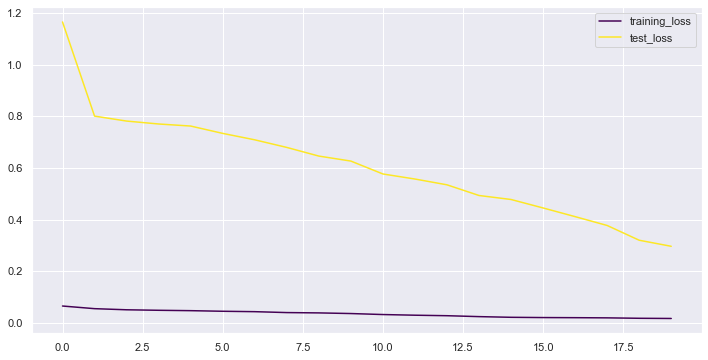

In [108]:
hist.plot(figsize=(12,6), cmap='viridis')
plt.show()

### Evaluate the model

In [109]:
predictions_descaled, labels_descaled = inference.predict(df=test_df,
                                                          label_name='Close',
                                                          sequence_length=sequence_length)

predictions_descaled.shape, predictions_descaled.shape

((63,), (63,))

In [110]:
print('Error on all test data:')
inference.print_loss_metrics(labels_descaled, predictions_descaled)
print('\n')
print('Error on partial test data:')
inference.print_loss_metrics(labels_descaled[:30], predictions_descaled[:30])

Error on all test data:
RMSE:  557.42
MAE:  466.58


Error on partial test data:
RMSE:  436.65
MAE:  390.78


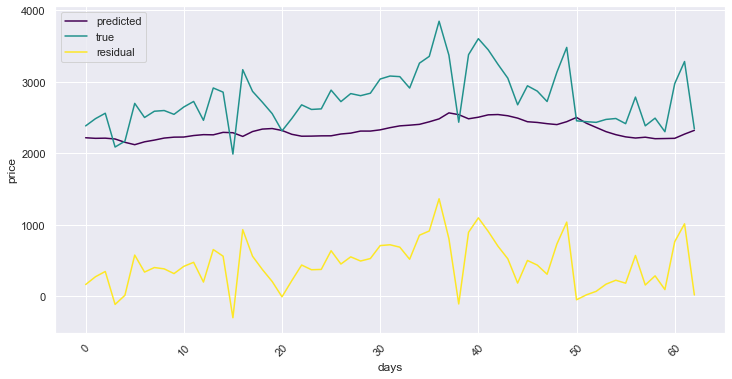

In [111]:
# plot predictions vs true values
df_pred = pd.DataFrame()
df_pred['predicted'] = predictions_descaled
df_pred['true'] = labels_descaled
df_pred['residual'] = labels_descaled - predictions_descaled
df_pred.plot(figsize=(12,6), cmap='viridis')
plt.xticks(rotation=45)
#plt.xlim(0,300)
plt.xlabel('days')
plt.ylabel('price')
plt.legend()
plt.show()

### Find important features

In [112]:
from train import TimeSeriesDataset, TSModel
from torch.utils.data import DataLoader
import torch
import shap

In [113]:
background_data_size = 900
test_sample_size = 100
sequence_length = 30

In [114]:
shap_values = interpret.get_important_features(
    background_data_size,
    test_sample_size,
    sequence_length
)

Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [115]:
shap_plot = pd.DataFrame(shap_values, columns=train_df.columns.tolist())
shap_plot['days'] = [i-31 for i in list(range(1,31))]
shap_plot.head()

,Close,Volume,High_Low_Pct,Open_Close_Pct,Week_of_Year,Month_Of_Year,Quarter_Of_Year,days
0,0.000002,7.963244e-08,2.065884e-08,2.793503e-08,1.417615e-07,7.833326e-08,1.232526e-07,-30
1,0.000003,1.495262e-07,6.531910e-09,1.490993e-08,2.203767e-07,8.414851e-08,1.407005e-07,-29
2,0.000002,2.565694e-07,2.963143e-08,6.556491e-09,3.354716e-07,6.565917e-08,1.470050e-07,-28
3,0.000001,4.125691e-07,9.299910e-08,3.699429e-08,4.922949e-07,1.431223e-08,1.260328e-07,-27
4,0.000001,6.393208e-07,2.163813e-07,8.862506e-08,6.925091e-07,1.316127e-07,5.127295e-08,-26


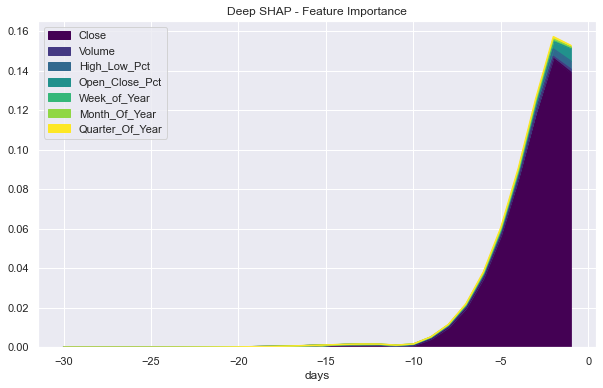

In [116]:
shap_plot.plot.area(x='days',figsize=(10, 6), cmap='viridis')
plt.title("Deep SHAP - Feature Importance")
plt.show()